In [52]:
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re2 as re
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from statsmodels.tsa.arima.model import ARIMA
from wordcloud import WordCloud, STOPWORDS


# Sugarbowl Exploratory page
**Syracuse University IST736 Summer 2025 by La Monte Henry Piggy Yarroll and JJ Balasi**

## Introduction

## Data

In [2]:
!pwd

/home/piggy/src/github.com/piggyatbaqaqi/sugarbowl/explore


In [3]:
raw_data_path = Path('../data/La_Monte_Yarroll_glucose_7-20-2025.csv')
raw_data = pd.read_csv(raw_data_path, header=1)

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Device                            124907 non-null  object 
 1   Serial Number                     124907 non-null  object 
 2   Device Timestamp                  124907 non-null  object 
 3   Record Type                       124907 non-null  int64  
 4   Historic Glucose mg/dL            106874 non-null  float64
 5   Scan Glucose mg/dL                12610 non-null   float64
 6   Non-numeric Rapid-Acting Insulin  0 non-null       float64
 7   Rapid-Acting Insulin (units)      0 non-null       float64
 8   Non-numeric Food                  0 non-null       float64
 9   Carbohydrates (grams)             50 non-null      float64
 10  Carbohydrates (servings)          0 non-null       float64
 11  Non-numeric Long-Acting Insulin   0 non-null       f

In [45]:
raw_data['Record Type'].value_counts()

Record Type
0    106874
1     12610
6      5373
5        50
Name: count, dtype: int64

In [48]:
raw_data[raw_data['Record Type'] == 5]

,Device,Serial Number,Device Timestamp,Record Type,Historic Glucose mg/dL,Scan Glucose mg/dL,Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Carbohydrates (servings),Non-numeric Long-Acting Insulin,Long-Acting Insulin (units),Notes,Strip Glucose mg/dL,Ketone mmol/L,Meal Insulin (units),Correction Insulin (units),User Change Insulin (units)
119491,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-24-2024 04:24 PM,5,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119492,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-24-2024 05:48 PM,5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119493,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-25-2024 11:54 AM,5,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119494,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-25-2024 05:42 PM,5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119495,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-25-2024 05:50 PM,5,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119496,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-25-2024 11:34 PM,5,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119497,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-26-2024 07:43 PM,5,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119498,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-27-2024 11:57 AM,5,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119499,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-27-2024 05:21 PM,5,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119500,FreeStyle Libre 3,0e154b86-bf50-4004-9ddb-123beeb2e7c4,06-27-2024 09:07 PM,5,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data = raw_data[['Record Type', 'Serial Number', 'Historic Glucose mg/dL', 'Scan Glucose mg/dL', 'Carbohydrates (grams)', 'Notes']].copy()

In [6]:
time_format = '%m-%d-%Y %I:%M %p'        
data.loc[:, 'timestamp'] = raw_data['Device Timestamp'].map(lambda t: datetime.strptime(t, time_format))
data.sort_values(by='timestamp', ascending=True, inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124907 entries, 1 to 106880
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Record Type             124907 non-null  int64         
 1   Serial Number           124907 non-null  object        
 2   Historic Glucose mg/dL  106874 non-null  float64       
 3   Scan Glucose mg/dL      12610 non-null   float64       
 4   Carbohydrates (grams)   50 non-null      float64       
 5   Notes                   1874 non-null    object        
 6   timestamp               124907 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 7.6+ MB


In [8]:
def get_meals(data: pd.DataFrame) -> pd.DataFrame:
    retval = data[(data['Record Type'] == 6) & (data['Notes'] != '')
                  & (data['Notes'].isna().map(lambda x: not x))]
    return retval.reset_index(drop=True)
meals = get_meals(data)
print(f"Number of meals: {len(meals)}")

Number of meals: 1874


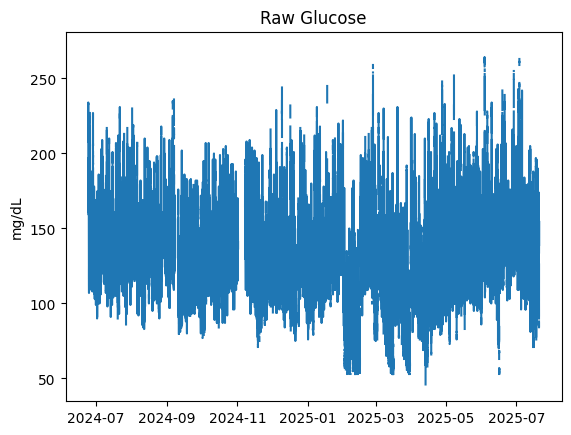

In [9]:
plt.plot(data['timestamp'], data['Historic Glucose mg/dL'])
plt.ylabel('mg/dL')
plt.title('Raw Glucose')
plt.show()

In [10]:
data['Serial Number'].value_counts()

Serial Number
0e154b86-bf50-4004-9ddb-123beeb2e7c4    124900
22c6a4d9-071c-476f-b04b-3d6ea3761356         6
a67a800c-57e1-46c9-b156-804a3a3f702a         1
Name: count, dtype: int64

In [11]:
# Define potential glucose columns and keep only those that exist
glucose_columns = [col for col in ['Scan Glucose mg/dL', 'Historic Glucose mg/dL', 'Strip Glucose mg/dL'] if col in data.columns]

# Use backfill to combine available glucose readings
data['glucose'] = data[glucose_columns].bfill(axis=1).iloc[:, 0]

print(f"DEBUG: {data['glucose'].isna().sum()}")

DEBUG: 5423


In [ ]:
DURATION = pd.Timedelta(hours=2)
# We want to interpret Glycemic Increment (G+) as "Meal raised glucose by G+ for 2 hours."
HOUR_ADJUST = 3600
MIN_RECORD_PCT = 0.90
DURATION_INCREMENT = pd.Timedelta(minutes=5)
def glycemic_increment(
    data: pd.DataFrame, when: pd.Timestamp, intermeal: pd.Timedelta = DURATION) -> Optional[np.float64]:
    '''Calculate the glycemic increment starting at when over interval intermeal.
    
    We assume that data contains only records with valid glucose values.
        
    Returns mg*hours/dL, or None if there is insufficient data.
    
    Meals are normalized to one hour.
    '''
    min_duration_count = int(MIN_RECORD_PCT * intermeal / DURATION_INCREMENT)
    # Calculate the end.
    end = when + intermeal
    # Find the start.
    i = (data['timestamp'] >= when).idxmax()
    if data['timestamp'][i] < when:
        print(f"DEBUG: Ran off end looking for start: {when}")
        return None  # We ran off the end
    # Extract the region.
    j = (data['timestamp'] >= end).idxmax()
    if j == 0:
        print("DEBUG: Ran off end looking for end: {end}")
        return None  # We ran off the end.
    
    if (j - i) < min_duration_count:
        # print(f"DEBUG: Not enough records: (j: {j} - i: {i}) = {j - i} < {min_duration_count}")
        return None  # There aren't enough records
    
    total = 0
    prev = data.iloc[i]
    first = prev
    for c in range(i, j):
        current = data.iloc[c]
        hours = (current['timestamp'] - prev['timestamp']).total_seconds() / HOUR_ADJUST
        total += (hours * (current['glucose'] - first['glucose']))
        prev = current

    meal_duration = (data.iloc[j]['timestamp'] - data.iloc[i]['timestamp']).total_seconds() / HOUR_ADJUST
    return total / meal_duration


def extend_meals(meals: pd.DataFrame, intermeal: pd.Timedelta) -> pd.DataFrame:
    '''Join meals that are close into one longer meal.'''
    result = []
    new_row = None
    for _, row in meals.iterrows():
        if new_row is None:
            new_row = row
            new_row['duration'] = intermeal
            continue
        if new_row['timestamp'] + new_row['duration'] < row['timestamp']:
            result.append(new_row)
            new_row = row
            new_row['duration'] = intermeal
            continue
        new_row['duration'] = row['timestamp'] - new_row['timestamp'] + intermeal
        if not np.isnan(row['Carbohydrates (grams)']):
            if np.isnan(new_row['Carbohydrates (grams)']):
                new_row['Carbohydrates (grams)'] = row['Carbohydrates (grams)']
            else:
                new_row['Carbohydrates (grams)'] += row['Carbohydrates (grams)']
        new_row['Notes'] += ' ' + row['Notes']
    result.append(new_row)
    print(f"DEBUG: {result}")
    return pd.concat(result, ignore_index=True, axis=1).T

In [71]:
sample_notes = [
    ("Ali Baba: falafel plate, baba ganoush",
     {'restaurant': 'ali baba', 'foods': [
         {'quantity': 1.0, 'unit': 'serving', 'item': 'falafel plate'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'baba ganoush'}
     ]}),

    ("2 glasses of milk, one with artificial sassafras and pineapple flavors and stevia",
     {'restaurant': None, 'foods': [
         {'quantity': 2.0, 'unit': 'glass', 'item': 'milk'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'artificial sassafras'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'pineapple flavors'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'stevia'}
     ]}),

    ("3.5oz Mingua Beef Jerky",
     {'restaurant': None, 'foods': [
         {'quantity': 3.5, 'unit': 'oz', 'item': 'mingua beef jerky'}
     ]}),

    ("2 slices of Ezekiel raisin toast, 3 egg scramble, garlic, mozzarella",
     {'restaurant': None, 'foods': [
         {'quantity': 2.0, 'unit': 'slic', 'item': 'ezekiel raisin toast'},
         {'quantity': 3.0, 'unit': 'serving', 'item': 'egg scramble'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'garlic'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'mozzarella'}
     ]}),

    ("Hunan Express: 5 pork dumplings",
     {'restaurant': 'hunan express', 'foods': [
         {'quantity': 5.0, 'unit': 'serving', 'item': 'pork dumplings'}
     ]}),

    ("Ali Baba: Veg trio: baba ganoush, sleek, taboule; falafel plate.",
     {'restaurant': 'ali baba', 'foods': [
         {'quantity': 1.0, 'unit': 'serving', 'item': 'baba ganoush'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'sleek'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'taboule'},
         {'quantity': 1.0, 'unit': 'serving', 'item': 'falafel plate'}
     ]}),
]

num = {
    'one': '1',
    'two': '2',
    'three': '3',
    'four': '4',
    'five': '5',
    'six': '6',
    'seven': '7',
    'eight': '8',
    'nine': '9'
}

num_re = re.compile(r'^(?P<num>[0-9.]+)(?P<unit>.*)$')

def parse_note(note: str) -> Dict[str, Union[int, str]]:
    retval = {}
    note = note.replace(' and ', ', ')
    note = note.replace(' with ', ', ')
    note = note.lower()
    with_restaurant = note.split(':', 1)
    if len(with_restaurant) > 1:
        retval['restaurant'] = with_restaurant[0]
        foods = with_restaurant[1]
    else:
        retval['restaurant'] = None
        foods = note
    food_elts = re.split(r'[,;]', foods)
    food_items = []
    for food in food_elts:
        food_elt = {}
        if ':' in food:  # There is a composite food. Just ignore the composite name.
            food = food.split(':', 1)[1]
        # Extract number
        food_parts = [f for f in food.split(' ') if f]
        rest = food_parts[:]
        if food_parts[0] in num:
            food_parts[0] = num[food_parts[0]]        
        num_match = num_re.match(food_parts[0])
        if num_match:
            quantity = num_match.group('num')
            unit = num_match.group('unit')
            rest = food_parts[1:]
        else:
            quantity = 1
            unit = 'serving'
        food_elt['quantity'] = float(quantity)
        if 'of' in rest:
            of_idx = rest.index('of')
            unit = ' '.join(rest[0:of_idx])
            item = ' '.join(rest[of_idx + 1:])
        else:
            if unit == '':
                unit = 'serving'
            item = ' '.join(rest)
        if unit.endswith('es'):
            unit = unit[:-2]
        elif unit.endswith('s'):
            unit = unit[:-1]
        food_elt['unit'] = unit
        item = item.strip()
        if item.endswith('.'):
            item = item[:-1]
        if not item:
            continue
        food_elt['item'] = item
        food_items.append(food_elt)
    retval['foods'] = food_items
    return retval

for note, result in sample_notes:
    print(f'note: {note}')
    try:
        assert(parse_note(note) == result)
    except AssertionError:
        print(f'parsed:\n\t{parse_note(note)}')
        print(f'Instead of:\n\t{result}')
        print()
        raise

note: Ali Baba: falafel plate, baba ganoush
note: 2 glasses of milk, one with artificial sassafras and pineapple flavors and stevia
note: 3.5oz Mingua Beef Jerky
note: 2 slices of Ezekiel raisin toast, 3 egg scramble, garlic, mozzarella
note: Hunan Express: 5 pork dumplings
note: Ali Baba: Veg trio: baba ganoush, sleek, taboule; falafel plate.


In [13]:
glucose_data = data.dropna(subset=['glucose']).copy().reset_index(drop=True)
glucose_data['glucose'] = pd.to_numeric(glucose_data['glucose'], errors='coerce')
glucose_data

,Record Type,Serial Number,Historic Glucose mg/dL,Scan Glucose mg/dL,Carbohydrates (grams),Notes,timestamp,glucose
0,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,208.0,NaN,NaN,NaN,2024-06-24 10:32:00,208.0
1,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,208.0,NaN,NaN,NaN,2024-06-24 10:37:00,208.0
2,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,219.0,NaN,NaN,NaN,2024-06-24 10:42:00,219.0
3,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,216.0,NaN,NaN,NaN,2024-06-24 10:47:00,216.0
4,1,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,219.0,NaN,NaN,2024-06-24 10:48:00,219.0
...,...,...,...,...,...,...,...,...
119479,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,155.0,NaN,NaN,NaN,2025-07-20 17:41:00,155.0
119480,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,154.0,NaN,NaN,NaN,2025-07-20 17:46:00,154.0
119481,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,150.0,NaN,NaN,NaN,2025-07-20 17:51:00,150.0
119482,0,0e154b86-bf50-4004-9ddb-123beeb2e7c4,143.0,NaN,NaN,NaN,2025-07-20 17:56:00,143.0


In [14]:
increments = meals.apply(lambda d: glycemic_increment(glucose_data, d['timestamp'], intermeal=DURATION), axis=1)   
# glycemic_increment(glucose_data, meals['timestamp'][10], intermeal=DURATION)
print(f"incomplete increments: {increments.isna().sum()}")
meals['increment'] = increments

incomplete increments: 26


In [15]:
extended_meals = extend_meals(meals, intermeal=DURATION)
extended_meals

DEBUG: [Record Type                                                  6
Serial Number             0e154b86-bf50-4004-9ddb-123beeb2e7c4
Historic Glucose mg/dL                                     NaN
Scan Glucose mg/dL                                         NaN
Carbohydrates (grams)                                      NaN
Notes                        Starbucks Bacon gruyere egg bites
timestamp                                  2024-06-24 10:50:00
increment                                                 2.75
duration                                       0 days 02:00:00
Name: 0, dtype: object, Record Type                                                         6
Serial Number                    0e154b86-bf50-4004-9ddb-123beeb2e7c4
Historic Glucose mg/dL                                            NaN
Scan Glucose mg/dL                                                NaN
Carbohydrates (grams)                                             NaN
Notes                     Spinach tomato omelet wit

,Record Type,Serial Number,Historic Glucose mg/dL,Scan Glucose mg/dL,Carbohydrates (grams),Notes,timestamp,increment,duration
0,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,Starbucks Bacon gruyere egg bites,2024-06-24 10:50:00,2.75,0 days 02:00:00
1,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"Spinach tomato omelet with Swiss, fruit cup",2024-06-24 13:53:00,14.373984,0 days 02:00:00
2,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"Coconut water, 2oz prosciutto Beef Carpaccio,...",2024-06-24 16:24:00,3.752066,0 days 03:37:00
3,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"Ezekiel toast, 2 eggs",2024-06-25 11:54:00,30.845528,0 days 02:00:00
4,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,5 lychees Peanut butter and buckwheat honey,2024-06-25 17:42:00,35.475,0 days 02:08:00
...,...,...,...,...,...,...,...,...,...
1066,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"6 apricots, 5 baby bananas, peanut butter, hon...",2025-07-18 20:27:00,24.540323,0 days 03:05:00
1067,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"Brueggers: skinny hot pastrami sandwich, pickle.",2025-07-19 08:20:00,28.661157,0 days 02:00:00
1068,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"DLCC: ramen, chocolate chunk cookie.",2025-07-19 12:41:00,49.133333,0 days 02:00:00
1069,6,0e154b86-bf50-4004-9ddb-123beeb2e7c4,NaN,NaN,NaN,"Nikki's Thai: 2 chicken satay, glass noodle sa...",2025-07-19 19:03:00,12.195122,0 days 03:50:00


In [16]:
extended_increments = extended_meals.apply(lambda d: glycemic_increment(glucose_data, d['timestamp'], intermeal=d['duration']), axis=1)   
extended_meals['increment'] = extended_increments
print(f"incomplete exteded increments: {extended_increments.isna().sum()}")

incomplete exteded increments: 16


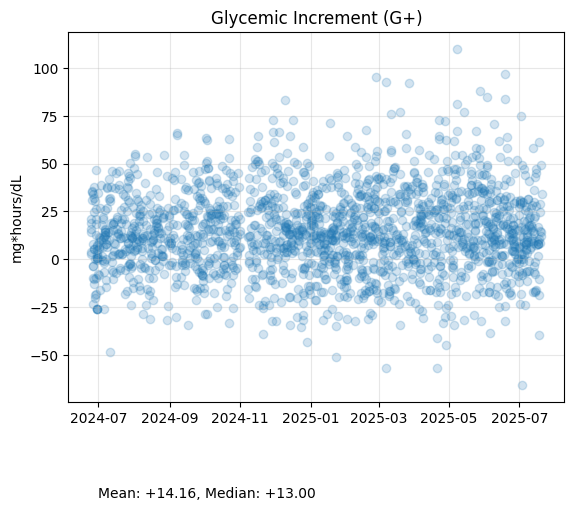

In [17]:
plt.scatter(meals['timestamp'], meals['increment'], alpha=0.2)
plt.grid(alpha=0.3)
plt.ylabel('mg*hours/dL')
plt.title('Glycemic Increment (G+)')
desc = meals['increment'].describe()
plt.text(pd.Timestamp('2024-07-01'), -125, f'Mean: {desc['mean']:+0.2f}, Median: {desc['50%']:+0.2f}')
plt.show()

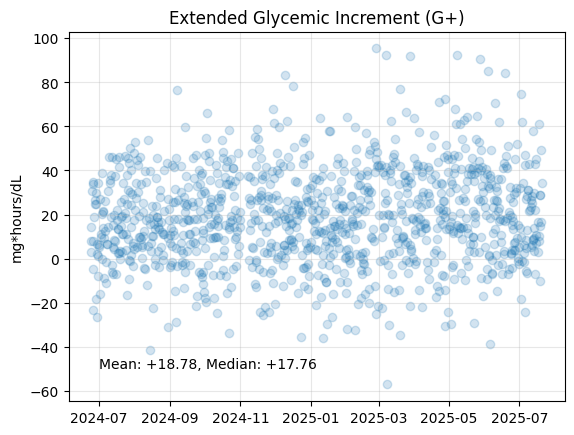

In [18]:
plt.scatter(extended_meals['timestamp'], extended_meals['increment'], alpha=0.2)
plt.grid(alpha=0.3)
plt.ylabel('mg*hours/dL')
plt.title('Extended Glycemic Increment (G+)')
desc = extended_meals['increment'].describe()
plt.text(pd.Timestamp('2024-07-01'), -50, f'Mean: {desc['mean']:+0.2f}, Median: {desc['50%']:+0.2f}')
plt.show()

In [19]:
meals['increment'].describe()

count    1848.000000
mean       14.156772
std        21.616056
min       -65.764228
25%         0.318648
50%        12.995833
75%        27.460417
max       110.033058
Name: increment, dtype: float64

Text(0.5, 1.0, 'all notes')

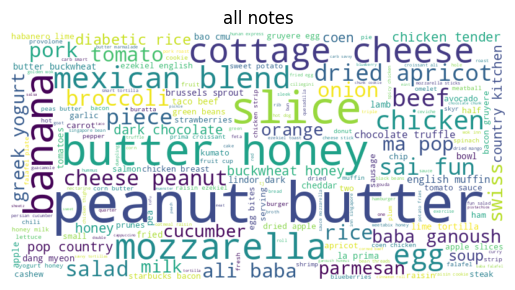

In [20]:
# Combine all notes into a single string
all_notes = ' '.join(meals['Notes']).lower()

# Create the WordCloud object
all_notes_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_notes)

plt.imshow(all_notes_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('all notes')


In [21]:
complete_meals = meals[['Notes', 'increment']].dropna()
complete_extended_meals = extended_meals[['Notes', 'increment']].dropna()

In [22]:
train_meals, test_meals = train_test_split(complete_meals, test_size=0.3, random_state=1701)
train_extended_meals, test_extended_meals = train_test_split(complete_extended_meals, test_size=0.3, random_state=1701)

In [23]:
meal_linear_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,3), binary=True)),
    ("model", LinearRegression()),
])
meal_linear_pipeline.fit(train_meals['Notes'], train_meals['increment'])

,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [24]:
extended_meal_linear_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(ngram_range=(1,3), binary=True)),
    ("model", LinearRegression()),
])
extended_meal_linear_pipeline.fit(train_extended_meals['Notes'], train_extended_meals['increment'])

,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


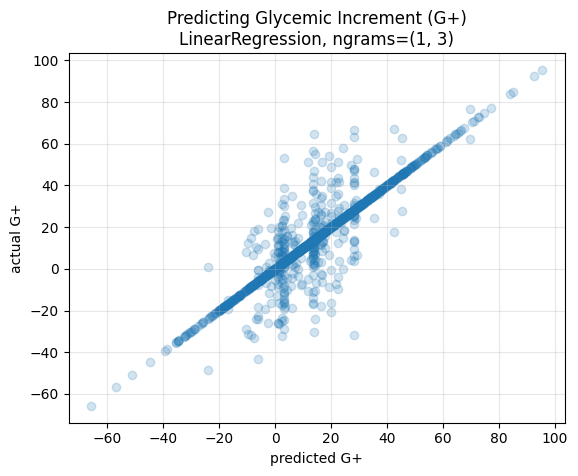

In [25]:
predicted = meal_linear_pipeline.predict(train_meals['Notes'])
plt.scatter(predicted, train_meals['increment'], alpha=0.2)
plt.grid(alpha=0.3)
plt.xlabel('predicted G+')
plt.ylabel('actual G+')
plt.title('Predicting Glycemic Increment (G+)\nLinearRegression, ngrams=(1, 3)')
plt.show()

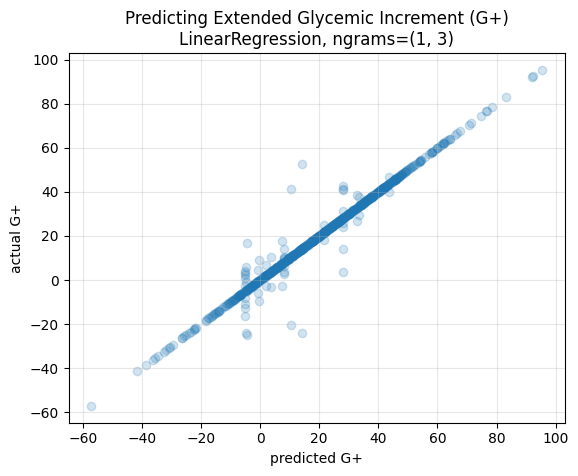

In [26]:
predicted = extended_meal_linear_pipeline.predict(train_extended_meals['Notes'])
plt.scatter(predicted, train_extended_meals['increment'], alpha=0.2)
plt.grid(alpha=0.3)
plt.xlabel('predicted G+')
plt.ylabel('actual G+')
plt.title('Predicting Extended Glycemic Increment (G+)\nLinearRegression, ngrams=(1, 3)')
plt.show()

In [43]:
extended_meals[extended_meals['increment'] < -20][['increment', 'Notes']].sort_values(by='increment')

,increment,Notes
688,-57.178862,"Cooked carrots, sugar snap peas, 3 pieces of l..."
142,-41.527919,"Beef jerky Peanut butter, buckwheat honey, hav..."
937,-38.675000,"Rice, masoor dal, pork, mozzarella, gruyere, B..."
537,-36.197279,"Banana. Peanut butter, butter, honey, havarti...."
483,-35.573770,"2 hot dogs, sweet potato fries, 6 flavor bomb ..."
720,-34.572581,"2 ribs, corn, butter."
324,-33.606557,"Peanut butter, Lindor dark chocolate truffle"
616,-32.629032,"Chicken soup, cheddar."
599,-31.889412,"⅓ of a pomelo Lamb curry, sugar snap peas, 2 s..."
176,-30.874016,"Pot roast, broccoli, mozzarella, broth Several..."


In [27]:
vectorizer = meal_linear_pipeline.named_steps['vectorizer']
feature_names = vectorizer.get_feature_names_out()
model = meal_linear_pipeline.named_steps['model']
named_coef = pd.DataFrame({'coef': model.coef_, 'features': feature_names})
named_coef.sort_values(by='coef', inplace=True)
named_coef.reset_index(drop=True, inplace=True)
named_coef

,coef,features
0,-71.789196,apricots banana
1,-36.647244,chicken tenders donut
2,-36.647244,tenders donut
3,-25.544046,prunes dried apricots
4,-21.756378,apple banana
...,...,...
8005,27.549354,apple plum
8006,36.819505,donut
8007,45.227064,croissant
8008,57.851182,slices raisins peanut


In [33]:
extended_vectorizer = extended_meal_linear_pipeline.named_steps['vectorizer']
extended_feature_names = extended_vectorizer.get_feature_names_out()
extended_model = extended_meal_linear_pipeline.named_steps['model']
print(f"extended_model.coef_: {len(extended_model.coef_)}")
print(f"extended_feature_names: {len(extended_feature_names)}")
extended_named_coef = pd.DataFrame({'coef': extended_model.coef_, 'features': extended_feature_names})
extended_named_coef.sort_values(by='coef', inplace=True)
extended_named_coef.reset_index(drop=True, inplace=True)
extended_named_coef

extended_model.coef_: 9734
extended_feature_names: 9734


,coef,features
0,-26.572421,cruller
1,-13.138603,thai beef
2,-13.138603,thai beef sai
3,-12.947650,kumato
4,-12.828468,milk peanut
...,...,...
9729,14.652176,butter honey butter
9730,14.671829,honey butter
9731,14.784917,cinnamon
9732,27.611023,giordano


In [34]:
named_coef[(named_coef['coef'] > -0.01) & (named_coef['coef'] < 0.025)]

,coef,features
3770,-0.002446,dill eggs ciliegine
3771,-0.002446,dill eggs
3772,-0.002446,eggs ciliegine
3773,-0.002446,butter dill
3774,-0.002446,noodle butter
3775,-0.002446,noodle butter dill
3776,-0.002446,miracle noodle butter
3777,-0.002446,miracle noodle
3778,-0.002446,butter dill eggs
3779,-0.002446,noodle


In [ ]:
extended_named_coef[(extended_named_coef['coef'] > -0.01) & (extended_named_coef['coef'] < 0.025)]

In [ ]:
def meal_plot(data: pd.DataFrame, when: pd.Timestamp, duration: float = DURATION, ax: Optional[plt.Axes] = None) -> Optional[np.float64]:
    '''Plot the glucose level for a meal starting at when.
    
    We assume that data contains only records with valid glucose values.
    '''
    # Calculate the end.
    end = when + duration
    # Find the start.
    i = (data['timestamp'] >= when).idxmax()
    if data['timestamp'][i] < when:
        print(f'Ran off end looking for start: {when}')
        return None  # We ran off the end
    # Extract the region.
    j = (data['timestamp'] >= end).idxmax()
    if j == 0:
        print(f'Ran off end looking for end: {end}')
        return None  # We ran off the end.
    
    if (j - i) < MIN_DURATION_COUNT:
        print(f"Not enough records: (j: {j} - i: {i}) = {j - i} < {MIN_DURATION_COUNT}")
        # There aren't enough records
    
    print(f"DEBUG: i: {i} j: {j}")
    meal_data = data.iloc[i:j]
    ax.scatter(meal_data['timestamp'], meal_data['glucose'])


In [ ]:
# meal = meals.iloc[meals['increment'].idxmin()]
meal = meals.iloc[6]
meal_plot(glucose_data, meal['timestamp'], duration=pd.Timedelta(hours=4), ax=plt)
meal

In [ ]:
def ginc_plot(data: pd.DataFrame, when: pd.Timestamp, duration: pd.Timedelta = DURATION, ax: Optional[plt.Axes] = None) -> Optional[np.float64]:
    '''Plot the glucose increment for a meal starting at when.
    
    We assume that data contains only records with valid glucose values.
    '''
    # Calculate the end.
    end = when + duration
    # Find the start.
    i = (data['timestamp'] >= when).idxmax()
    if data['timestamp'][i] < when:
        print(f'Ran off end looking for start: {when}')
        return None  # We ran off the end
    # Extract the region.
    j = (data['timestamp'] >= end).idxmax()
    if j == 0:
        print(f'Ran off end looking for end: {end}')
        return None  # We ran off the end.
    
    if (j - i) < MIN_DURATION_COUNT:
        print(f"Not enough records: (j: {j} - i: {i}) = {j - i} < {MIN_DURATION_COUNT}")
        # There aren't enough records
    
    print(f"DEBUG: i: {i} j: {j}, data.iloc[i]['glucose']: {data.iloc[i]['glucose']}")
    meal_data = data.iloc[i:j].reset_index(drop=True)
    bottom = data.iloc[i]['glucose'] - 10
    
    ax.bar(meal_data['timestamp'], meal_data['glucose'] - bottom, bottom=bottom, width=pd.Timedelta(minutes=5), color='tab:blue')
    ax.bar(meal_data['timestamp'], [10] * len(meal_data['timestamp']), bottom=132, width=pd.Timedelta(minutes=5), color='tab:orange')
    ax.scatter(meal_data['timestamp'], meal_data['glucose'], color='tab:green')
    ax.ylabel('mg/dL')
    ax.title('Green: glucose, Blue: G+, Orange: subtracted')
    return meal_data


In [ ]:
meal = meals.iloc[6]
meal_data = ginc_plot(glucose_data, meal['timestamp'], duration=pd.Timedelta(hours=3.5), ax=plt)
plt.show()

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
import pandas as pd
import numpy as np
output_notebook()
source = ColumnDataSource(data)
tools = "pan,wheel_zoom,box_zoom,reset,save,hover"
p = figure(title="Interactive Bokeh Scatter Plot", tools=tools)
p.scatter(x='timestamp', y='glucose', source=source, size=10, color='blue', alpha=0.6, legend_field='category')
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("timestamp", "@x"),
    ("glucose", "@y"),
    ("Record Type", "@category"),
    ("Value", "@value")
]
show(p)

## Methods and Models

## Experimental Design and Investigation Strategy

## Results and Observations

## Conclusions

## Appendix

## Bibliography